In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection

#### census data

In [2]:
census_path = '../Project 1/census/'

In [3]:
with open(os.path.join(census_path, 'adult.names')) as f:
    names = f.readlines()
cols = [c for c in names if c[0] != '|']
cols = [c.replace('\n', '') for c in cols]
cols = [c.split(':')[0] for c in cols]
cols = [c for c in cols if c]
cols = cols[1:] + [cols[0]]
df_census = pd.read_csv(os.path.join(census_path, 'adult.data'), names=cols)

In [4]:
X_census_cols = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'
]
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'
]
X_census = pd.get_dummies(df_census[X_census_cols], columns=categorical_cols, drop_first=True)
y_census = df_census['>50K, <=50K.'].map(lambda x: {'>50K': 1, '<=50K': 0}.get(x.strip()))

In [5]:
X_census_train, X_census_test, y_census_train, y_census_test = train_test_split(
    X_census, y_census, stratify=y_census, train_size=.8, shuffle=True, random_state=42
)

In [6]:
ss = StandardScaler()
x_cols = X_census.columns
X_census_train = ss.fit_transform(X_census_train)
X_census_test = ss.transform(X_census_test)

#### spam data

In [7]:
spam_path = '../Project 1/spam/'

In [8]:
with open(os.path.join(spam_path, 'spambase.names')) as f:
    names = f.readlines()
cols = [c for c in names if c[0] != '|']
cols = [c.replace('\n', '') for c in cols]
cols = [c.split(':')[0] for c in cols]
cols = [c for c in cols if c]
spam_cols = cols[1:]

In [9]:
df_spam = pd.read_csv(os.path.join(spam_path, 'spambase.data'), header=None)

In [10]:
X_spam_cols = df_spam.columns[:-1]
y_spam_col = df_spam.columns.difference(X_spam_cols)[0]
X_spam = df_spam[X_spam_cols]
y_spam = df_spam[y_spam_col]

In [11]:
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(
    X_spam, y_spam, stratify=y_spam, train_size=.8, shuffle=True, random_state=42
)

In [12]:
ss = StandardScaler()
x_cols = X_spam.columns
X_spam_train = ss.fit_transform(X_spam_train)
X_spam_test = ss.transform(X_spam_test)

#### visualize cluster

In [13]:
def viz_clusters(X, clusters, i=0, j=1):
    pca = PCA()
    x = pca.fit_transform(X)
    x1 = x[:, i]
    x2 = x[:, j]
    fig, ax = plt.subplots(figsize=(16,9))
    plot = ax.scatter(x1, x2, c=clusters, alpha=.2)
    var1 = round(pca.explained_variance_ratio_[i], 2)
    var2 = round(pca.explained_variance_ratio_[j], 2)
    ax.set_xlabel(f'PCA Component {i} - Percent Explained Variance {var1}')
    ax.set_ylabel(f'PCA Component {j} - Percent Explained Variance {var2}')
    leg = ax.legend(*plot.legend_elements())
    for lh in leg.legendHandles:
        lh._legmarker.set_alpha(1)

In [14]:
def elbow_plot(scores, metric, figsize=(5,3)):
    scores = pd.Series(scores)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(scores.index, scores.values)
    ax.set_title('Elbow Plot')
    ax.set_ylabel(metric.title())
    ax.set_xlabel('K')

In [15]:
def calc_silhouette(d, c, alg):
    if alg == 'soft':
        n, m = c.shape
        scores = np.zeros(c.shape)
        for i in range(m):
            a = (d * c[:, i]).sum(axis=1) / np.dot(1-np.eye(n), c[:,i])
            b = np.zeros((n, m-1))
            for j in range(m):
                if i == j:
                    continue
                idx = j - (1 * (j > i))
                b[:, idx] = (d * c[:, j]).sum(axis=1) / np.dot(1-np.eye(n), c[:,j])
            b = b.min(axis=1)
            scores[:, i] = (b - a)/np.array([a, b]).max(axis=0)
        score = (scores * c).sum() / c.sum()
    elif alg == 'hard':
        if len(c.shape) > 1:
            if c.shape[1] > 1:
                c = c.argmax(axis=1)
            elif c.shape[1] == 1:
                c = c.reshape(-1)
        score = silhouette_score(d, c, metric='precomputed')
    return score

#### census prep

In [16]:
results = {
    'em_census_pca': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_census_pca': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'em_census_ica': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_census_ica': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'em_census_rp': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_census_rp': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'em_census_rf': {'log_likelihood': '', 'final': {'silhouette': '', 'information_gain': ''}},
    'km_census_rf': {'silhouette': '', 'final': {'silhouette': '', 'information_gain': ''}},
}
X = X_census_train.copy()
y = y_census_train.copy()
X_val = X_census_test.copy()

#### reduce data - census

In [17]:
pca = PCA(15, random_state=4200)
X_pca = pca.fit_transform(X)
X_val_pca = pca.transform(X_val)

In [18]:
ica = FastICA(12, random_state=4200)
X_ica = ica.fit_transform(X)
X_val_ica = ica.transform(X_val)

In [19]:
rp = GaussianRandomProjection(20, random_state=4200)
X_rp = rp.fit_transform(X)
X_val_rp = rp.transform(X_val)

In [20]:
# random forest
X_rf = X[:, [30, 3, 2, 32]].copy()
X_val_rf = X_val[:, [30, 3, 2, 32]].copy()

#### distance - census

In [21]:
dist_pca = distance_matrix(X_pca, X_pca)
dist_ica = distance_matrix(X_ica, X_ica)
dist_rp = distance_matrix(X_rp, X_rp)
dist_rf = distance_matrix(X_rf, X_rf)

#### clustering - EM PCA census

In [22]:
X = X_pca.copy()
X_val = X_val_pca.copy()
y = y.copy()
dist = dist_pca
model = GaussianMixture
alg = 'soft'
fname = 'em_census_pca.csv'

In [23]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [24]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

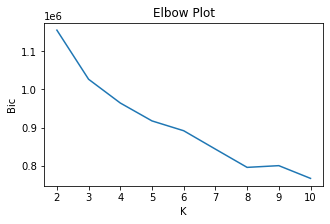

In [25]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

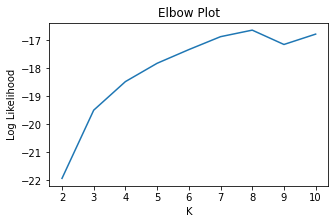

In [26]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [27]:
pd.concat([df.filter(like='8_').mean(), df.filter(like='8_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
8_0,0.128275,0.128033
8_1,0.086465,0.086763
8_2,0.120749,0.120739
8_3,0.138186,0.137208
8_4,0.131273,0.131411
8_5,0.148130,0.147497
8_6,0.106779,0.107148
8_7,0.140141,0.141201


In [28]:
# choose k
k = 8
alt_k = 10
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [29]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.024897390093157605

In [30]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

0.04431246580525849

In [31]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.241 

8_0    0.492
8_1    0.113
8_2    0.477
8_3    0.202
8_4    0.350
8_5    0.190
8_6    0.059
8_7    0.014
dtype: float64


In [32]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.241 

10_0    0.100
10_1    0.113
10_2    0.696
10_3    0.314
10_4    0.101
10_5    0.305
10_6    0.033
10_7    0.001
10_8    0.469
10_9    0.078
dtype: float64


In [33]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.12732023933340786

In [34]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

0.18010452621132866

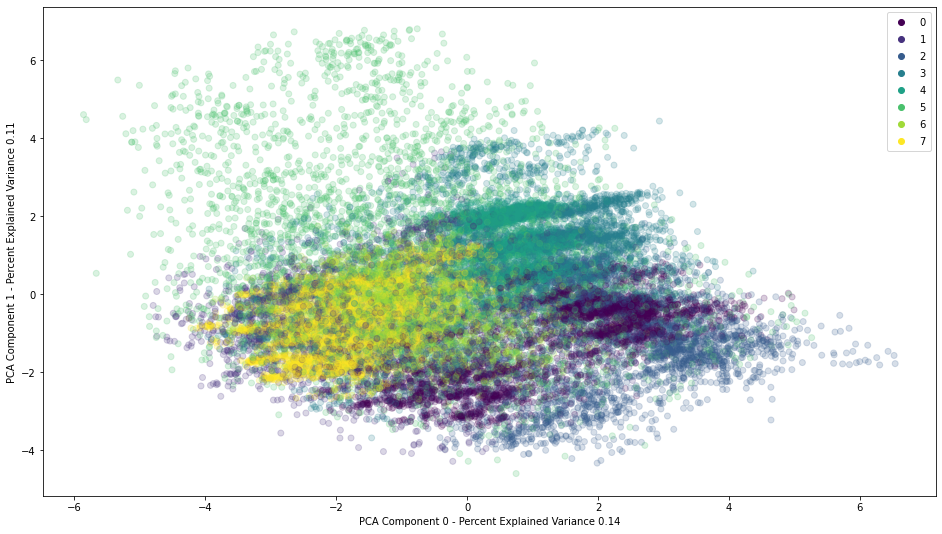

In [35]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means PCA census

In [36]:
X = X_pca.copy()
y = y.copy()
X_val = X_val_pca.copy()
dist = dist_pca
model = KMeans
alg = 'hard'
fname = 'km_census_pca.csv'

In [37]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [38]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

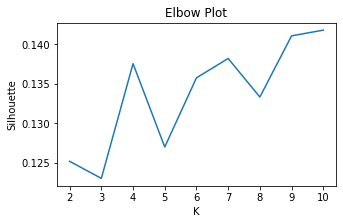

In [39]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [40]:
df[4].value_counts(normalize=True)

1    0.469940
0    0.455966
2    0.047451
3    0.026643
Name: 4, dtype: float64

In [41]:
df[7].value_counts(normalize=True)

1    0.284744
0    0.237715
3    0.172720
6    0.144848
4    0.095631
5    0.039235
2    0.025107
Name: 7, dtype: float64

In [42]:
# choose k
k = 4
alt_k = 7
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [43]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.13754763056568442

In [44]:
calc_silhouette(dist, df[alt_k].values, alg)

0.138201000154789

In [45]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.241 

4
0    0.450
1    0.052
2    0.066
3    0.294
Name: label, dtype: float64


In [46]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.241 

7
0    0.074
1    0.326
2    0.281
3    0.636
4    0.108
5    0.054
6    0.008
Name: label, dtype: float64


In [47]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.16491118370213265

In [48]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

0.19290965370690671

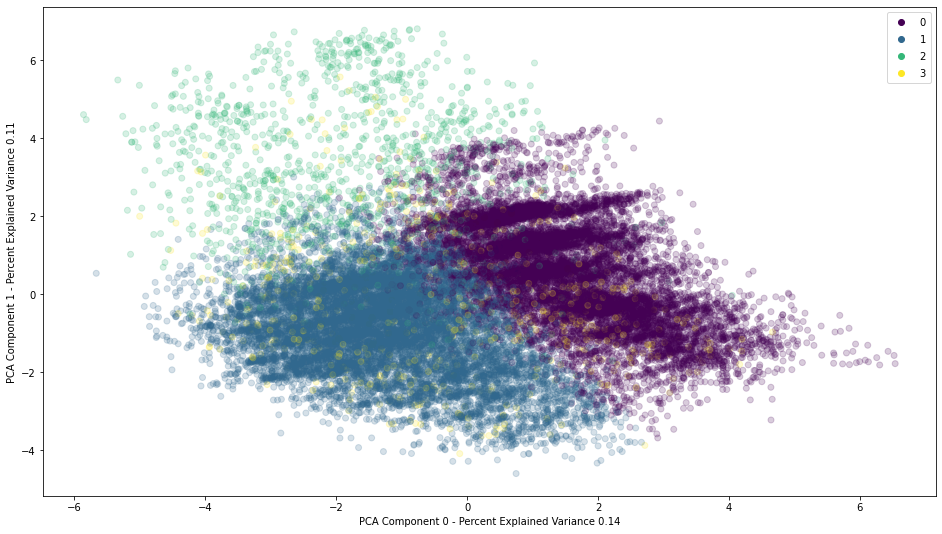

In [49]:
# visualize clusters
viz_clusters(X, df[k])

#### clustering - EM ICA census

In [50]:
X = X_ica.copy()
X_val = X_val_ica.copy()
y = y.copy()
dist = dist_ica
model = GaussianMixture
alg = 'soft'
fname = 'em_census_ica.csv'

In [51]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [52]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

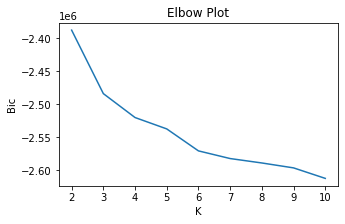

In [53]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

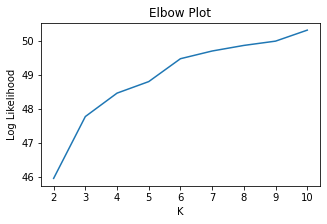

In [54]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [55]:
pd.concat([df.filter(like='4_').mean(), df.filter(like='4_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
4_0,0.394056,0.397190
4_1,0.224690,0.223741
4_2,0.089224,0.087300
4_3,0.292030,0.291769


In [56]:
# choose k
k = 4
alt_k = 7
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [57]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.05025182655920396

In [58]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

0.06894439416905832

In [59]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.241 

4_0    0.333
4_1    0.111
4_2    0.454
4_3    0.151
dtype: float64


In [60]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.241 

7_0    0.042
7_1    0.042
7_2    0.340
7_3    0.457
7_4    0.086
7_5    0.412
7_6    0.113
dtype: float64


In [61]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.05402590222134296

In [62]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

0.14481199871158656

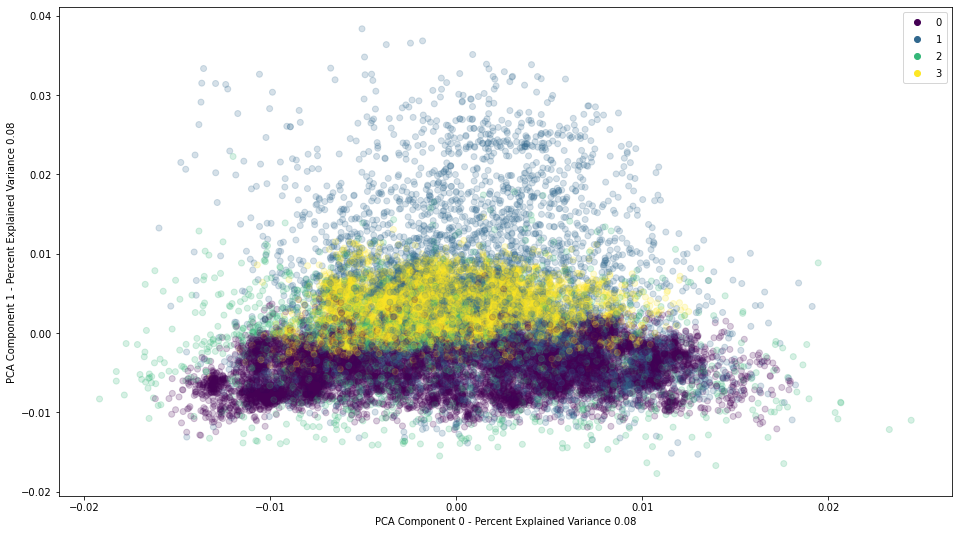

In [63]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means ICA census

In [64]:
X = X_ica.copy()
y = y.copy()
X_val = X_val_ica.copy()
dist = dist_ica
model = KMeans
alg = 'hard'
fname = 'km_census_ica.csv'

In [65]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [66]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

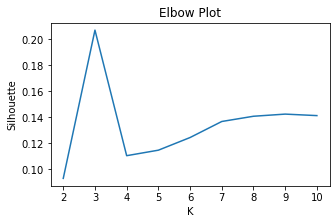

In [67]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [68]:
df[4].value_counts(normalize=True)

0    0.474777
3    0.387938
1    0.104077
2    0.033208
Name: 4, dtype: float64

In [69]:
df[7].value_counts(normalize=True)

5    0.281212
4    0.236563
3    0.157248
1    0.109260
6    0.097205
0    0.087646
2    0.030866
Name: 7, dtype: float64

In [70]:
# choose k
k = 4
alt_k = 7
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [71]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.11043660806726348

In [72]:
calc_silhouette(dist, df[alt_k].values, alg)

0.13669763340543212

In [73]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.241 

4
0    0.347
1    0.116
2    0.274
3    0.142
Name: label, dtype: float64


In [74]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.241 

7
0    0.049
1    0.504
2    0.267
3    0.494
4    0.168
5    0.159
6    0.112
Name: label, dtype: float64


In [75]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.04390990296569297

In [76]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

0.09728430672926214

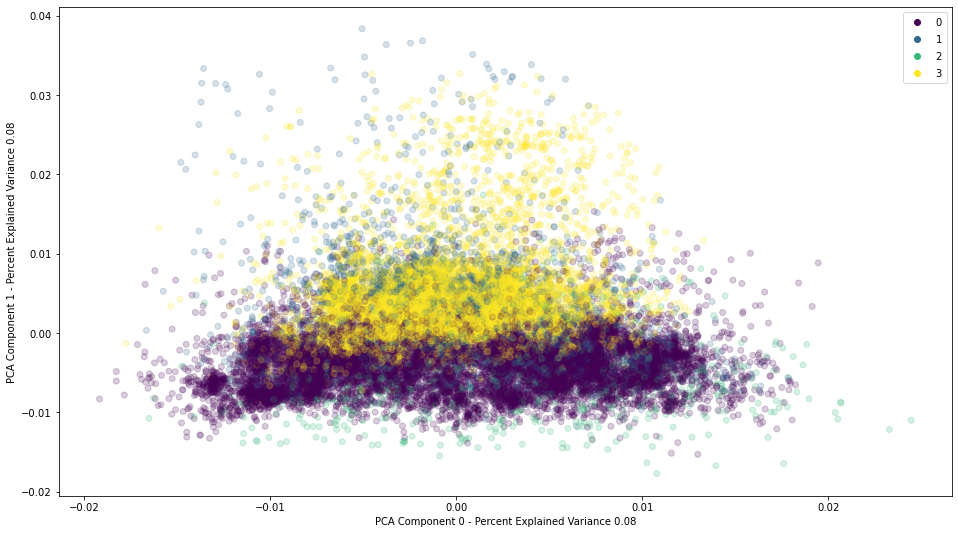

In [77]:
# visualize clusters
viz_clusters(X, df[k])

#### clustering - EM RP census

In [78]:
X = X_rp.copy()
X_val = X_val_rp.copy()
y = y.copy()
dist = dist_rp
model = GaussianMixture
alg = 'soft'
fname = 'em_census_rp.csv'

In [79]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [80]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

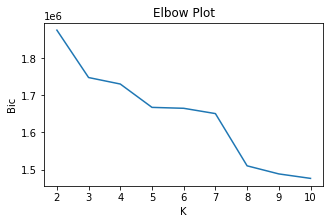

In [81]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

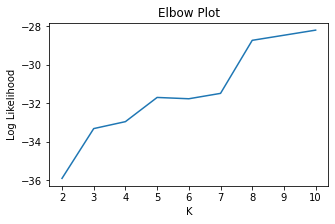

In [82]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [83]:
pd.concat([df.filter(like='8_').mean(), df.filter(like='8_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
8_0,0.184040,0.184045
8_1,0.261491,0.263590
8_2,0.165272,0.165349
8_3,0.081621,0.080659
8_4,0.000576,0.000576
8_5,0.012057,0.012055
8_6,0.047176,0.047105
8_7,0.247767,0.246622


In [84]:
# choose k
k = 8
alt_k = 3
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [85]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

-0.029865928538269467

In [86]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

0.04622021592932026

In [87]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.241 

8_0    0.056
8_1    0.431
8_2    0.178
8_3    0.340
8_4    0.133
8_5    0.207
8_6    0.126
8_7    0.210
dtype: float64


In [88]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.241 

3_0    0.23
3_1    0.26
3_2    0.22
dtype: float64


In [89]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.07542171584554791

In [90]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

0.0009991520984136137

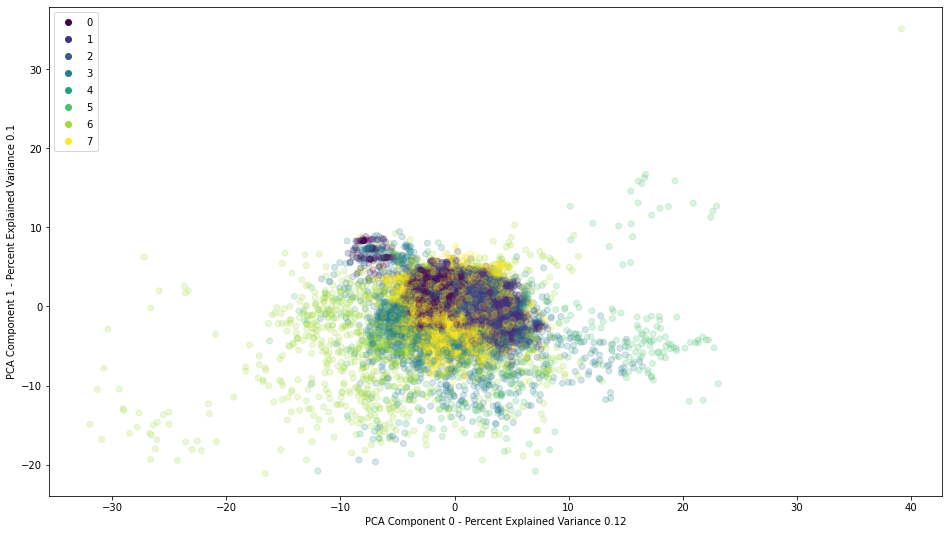

In [91]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means RP census

In [92]:
X = X_rp.copy()
y = y.copy()
X_val = X_val_rp.copy()
dist = dist_rp
model = KMeans
alg = 'hard'
fname = 'km_census_rp.csv'

In [93]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [94]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

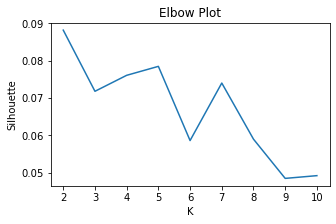

In [95]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [96]:
df[2].value_counts(normalize=True)

1    0.50453
0    0.49547
Name: 2, dtype: float64

In [97]:
df[5].value_counts(normalize=True)

1    0.461955
0    0.455352
3    0.062884
4    0.015548
2    0.004261
Name: 5, dtype: float64

In [98]:
# choose k
k = 2
alt_k = 5
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [99]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.08820221456352965

In [100]:
calc_silhouette(dist, df[alt_k].values, alg)

0.07848427577445859

In [101]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.241 

2
0    0.102
1    0.377
Name: label, dtype: float64


In [102]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.241 

5
0    0.108
1    0.393
2    0.180
3    0.083
4    0.254
Name: label, dtype: float64


In [103]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

0.07870603453392455

In [104]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

0.0833759025462546

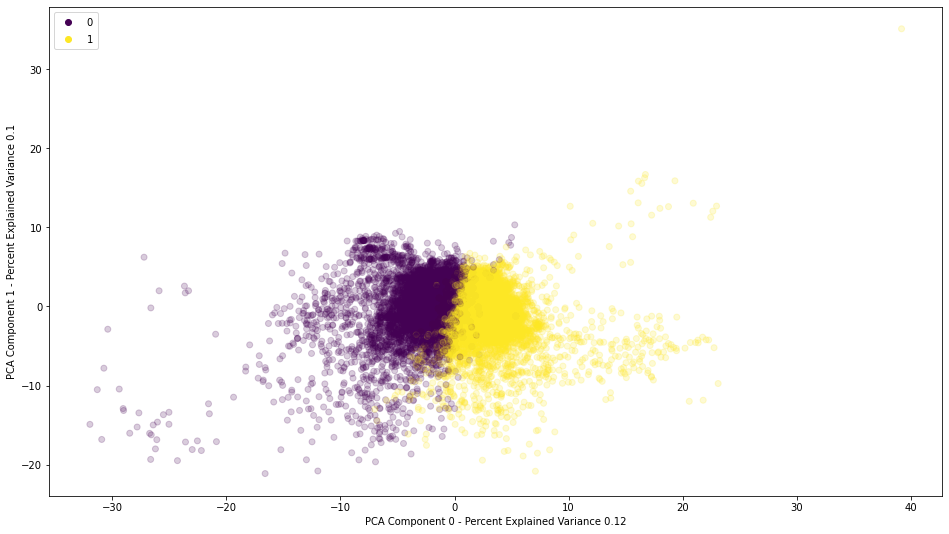

In [105]:
# visualize clusters
viz_clusters(X, df[k])

#### clustering - EM RF census

In [106]:
X = X_rf.copy()
X_val = X_val_rf.copy()
y = y.copy()
dist = dist_rf
model = GaussianMixture
alg = 'soft'
fname = 'em_census_rf.csv'

In [107]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict_proba(X)
    cols = [f'{k}_{i}' for i in range(k)]
    for i, col in enumerate(cols):
        df[col] = y_pred[:, i]

In [108]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

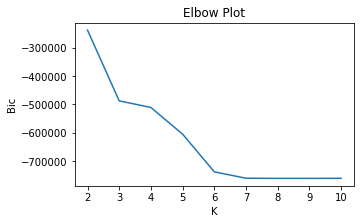

In [109]:
# choose k - BIC
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].bic(X)
elbow_plot(scores, 'BIC')

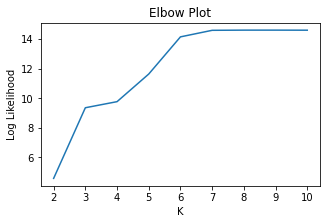

In [110]:
# choose k - log likelihood
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = models[k].score(X_val)
results[fname.replace('.csv', '')]['log_likelihood'] = scores
elbow_plot(scores, 'Log Likelihood')

In [111]:
pd.concat([df.filter(like='6_').mean(), df.filter(like='6_').idxmax(axis=1).value_counts(normalize=True)], axis=1)

,0,1
6_0,0.064573,0.064573
6_1,0.405290,0.405290
6_2,0.312836,0.312846
6_3,0.004760,0.004760
6_4,0.013177,0.013168
6_5,0.199363,0.199363


In [112]:
# choose k
k = 6
alt_k = 3
k_cols = df.filter(like=f'{k}_').columns
alt_k_cols = df.filter(like=f'{alt_k}_').columns

In [113]:
# validate - silhouette
sil = calc_silhouette(dist, df[k_cols].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.41721282160531953

In [114]:
calc_silhouette(dist, df[alt_k_cols].values, alg)

0.42400077617172

In [115]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print((df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()).round(3))

0.241 

6_0    0.653
6_1    0.406
6_2    0.035
6_3    1.000
6_4    0.321
6_5    0.073
dtype: float64


In [116]:
print(round(df['label'].mean(), 3), '\n')
print((df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()).round(3))

0.241 

3_0    0.620
3_1    0.296
3_2    0.035
dtype: float64


In [117]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[k_cols].apply(lambda x: x * df['label']).sum() / df[k_cols].sum()
q = df[k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k_cols].mean()).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

/Users/dan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.18677304268356965

In [118]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df[alt_k_cols].apply(lambda x: x * df['label']).sum() / df[alt_k_cols].sum()
q = df[alt_k_cols].apply(lambda x: x * (1-df['label'])).sum() / df[alt_k_cols].sum()
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k_cols].mean()).sum()
ig = h1 - h2
ig

0.11973413113854436

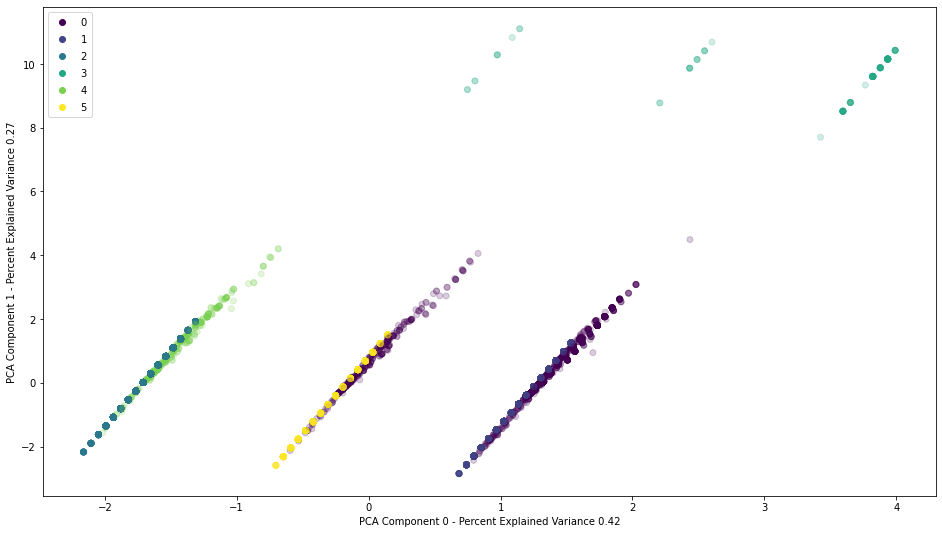

In [119]:
# visualize clusters
viz_clusters(X, df[k_cols].idxmax(axis=1).map(lambda x: x[2:]).astype(int))

#### clustering - K Means RF census

In [120]:
X = X_rf.copy()
y = y.copy()
X_val = X_val_rf.copy()
dist = dist_rf
model = KMeans
alg = 'hard'
fname = 'km_census_rf.csv'

In [121]:
# generate data
seed = 42
min_k = 2
max_k = 10
df = pd.DataFrame(index=range(X.shape[0]))
models = {}
for k in range(min_k, max_k+1):
    model_k = model(k, random_state=seed)
    model_k.fit(X)
    models[k] = model_k
    y_pred = model_k.predict(X)
    col = k
    df[col] = y_pred

In [122]:
# save results (and add label)
df['label'] = y.values
df.to_csv(os.path.join('./results/', fname))

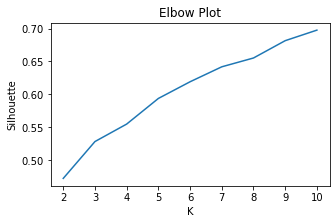

In [123]:
# choose k - silhouette
scores = {}
for k in range(min_k, max_k+1):
    scores[k] = silhouette_score(dist, df[k], metric='precomputed')
results[fname.replace('.csv', '')]['silhouette'] = scores
elbow_plot(scores, 'Silhouette')

In [124]:
df[5].value_counts(normalize=True)

1    0.326014
3    0.306281
2    0.210573
0    0.152373
4    0.004760
Name: 5, dtype: float64

In [125]:
df[7].value_counts(normalize=True)

4    0.269733
2    0.241209
0    0.190418
1    0.150568
5    0.082885
6    0.060427
3    0.004760
Name: 7, dtype: float64

In [126]:
# choose k
k = 5
alt_k = 7
k_cols = df.filter(like=f'{k}').columns
alt_k_cols = df.filter(like=f'{alt_k}').columns

In [127]:
# validate - silhouette
sil = calc_silhouette(dist, df[k].values, alg)
results[fname.replace('.csv', '')]['final']['silhouette'] = sil
sil

0.593931024304437

In [128]:
calc_silhouette(dist, df[alt_k].values, alg)

0.6419050161587166

In [129]:
# validate - labels mean
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(k)['label'].mean().round(3))

0.241 

5
0    0.693
1    0.046
2    0.086
3    0.318
4    1.000
Name: label, dtype: float64


In [130]:
print(round(df['label'].mean(), 3), '\n')
print(df.groupby(alt_k)['label'].mean().round(3))

0.241 

7
0    0.095
1    0.691
2    0.016
3    1.000
4    0.350
5    0.135
6    0.072
Name: label, dtype: float64


In [131]:
# validate - information gain
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[k].value_counts(normalize=True)).sum()
ig = h1 - h2
results[fname.replace('.csv', '')]['final']['information_gain'] = ig
ig

/Users/dan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.20732420429384413

In [132]:
p = df['label'].mean()
q = 1 - p
h1 = (-p * np.log2(p)) + (-q * np.log2(q))
p = df.groupby(alt_k)['label'].mean()
q = 1 - p
h2 = (((-p * np.log2(p)).fillna(0) + (-q * np.log2(q)).fillna(0)) * df[alt_k].value_counts(normalize=True)).sum()
ig = h1 - h2
ig

0.22510047892360463

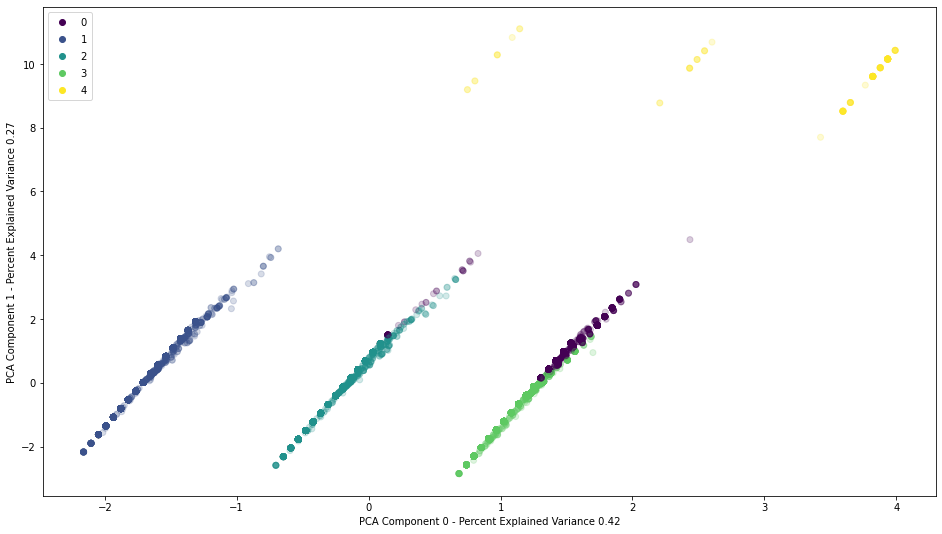

In [133]:
# visualize clusters
viz_clusters(X, df[k])

#### saving

In [134]:
for name, model_results in results.items():
    path = f'./results/{name}'
    for results_name, data in model_results.items():
        full_path = f'{path}_{results_name}.csv'
        if isinstance(data, pd.DataFrame):
            data.to_csv(full_path)
        elif isinstance(data, dict):
            pd.DataFrame(data, index=[0]).to_csv(full_path)